# 2D guidance deformation

In [ ]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/drive/folders/1SRWjFd98IfoWbOm20_RnB90DKem6RYaY?usp=sharing",

    # Networks
    'hidden_dim' : 256,
    'print_debug' : True,
    'verts_dim' : 3,
    'emb_net_depth' : 4,
    'disp_dim' : 1,
    'disp_net_depth' : 2,
    'norm_ratio' : 0.1,

    # Rendering
    'rendered_items' : 4,
    'net_rendered_items' : 16
}

!pip install gdown open3d --quiet

import copy
import gdown
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import os
import pickle as pkl
import plotly.graph_objects as go
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms
from tqdm import trange
from tqdm import tqdm

if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
    # We try to install PyTorch3D via a released wheel.
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install fvcore iopath
    !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
else:
    # We try to install PyTorch3D from source.
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

from pytorch3d.io import load_objs_as_meshes, load_obj # Util function for loading meshes
from pytorch3d.structures import Meshes # Data structures and functions for rendering
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    Textures,
    TexturesUV,
    TexturesVertex
)

o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

if not os.path.exists(global_var['mesh_data_path']):
    print("[LOG] Starting dataset download...")
    gdown.download_folder(url = global_var['mesh_data_url'],
        output = global_var['mesh_data_path'],
        quiet=True)
    print("[LOG] Dataset download ended!")

else:
    print("[LOG] Mesh dataset already downloaded!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=f4777c5aed945af13f68e499db685f8763c744bb5be8b1f023289c14e83d8584
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha25

In [ ]:
def get_dataset_meshes(dataset_path):
    meshes_paths = []
    meshes = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)

    meshes_paths.sort()

    for m in meshes_paths:
        meshes.append(load_objs_as_meshes([m],device=device))

    return meshes_paths, meshes

def get_mesh(obj_path):
    verts, faces_idxs, _ = load_obj(obj_path)
    faces = faces_idxs.verts_idx

    # Initialize each vertex to be white in color since this feature isn't required in our project
    verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    mesh = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
    )

    return mesh

meshes_paths, meshes = get_dataset_meshes(global_var['mesh_data_path'])

In [ ]:
def arch_differentiable_renderer(mesh, dist_in, elev_in, ang_in, items, device):
    distances = dist_in
    elevations = elev_in
    angles = ang_in
    rendered_images = []

    # for idx in tqdm(range(items), desc="Rendering",leave=True):
    for idx in range(items):
        R, T = look_at_view_transform(
            distances[idx],
            elevations[idx],
            angles[idx],
            degrees=True)

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=1,
        )

        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=device,
                cameras=cameras,
                lights=lights
            )
        )

        rendered_images.append(renderer(mesh))

    return rendered_images

In [ ]:
input_mesh = get_mesh(meshes_paths[9]) # Cono

dist_in = np.arange(2, 3.51, 0.05).tolist()
elev_in = np.arange(0, 360, 11.8).tolist()
ang_in = np.arange(0, 360, 11.8).tolist()

guidances_2d = arch_differentiable_renderer(get_mesh(meshes_paths[1]),dist_in,elev_in,ang_in,global_var['net_rendered_items'],device) # Mezzo cilindro
rendered_input = arch_differentiable_renderer(get_mesh(meshes_paths[9]),dist_in,elev_in,ang_in,global_var['net_rendered_items'],device) # Mezzo cilindro

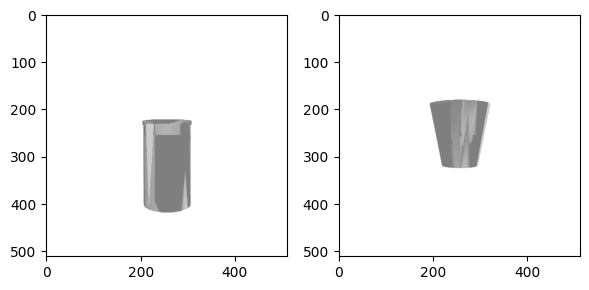

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(6,4))
ax[0].imshow(guidances_2d[0][0, ..., :3].detach().cpu().numpy())
ax[1].imshow(rendered_input[0][0, ..., :3].detach().cpu().numpy())

plt.tight_layout()
plt.show()

In [ ]:
class Displacement_Net(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, disp_dim=1, norm_ratio=0.1):
        super(Displacement_Net, self).__init__()

        self.l1 = nn.Linear(verts_dim,hidden_dim)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim,hidden_dim)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_dim,disp_dim)

        self.norm_ratio = norm_ratio

    def forward(self, x):
        y1 = torch.nn.functional.linear(x, self.l1.weight.clone(), self.l1.bias)
        y2 = self.a1(y1)

        y3 = torch.nn.functional.linear(y2, self.l2.weight.clone(), self.l2.bias)
        y4 = self.a2(y3)

        y5 = torch.nn.functional.linear(y4, self.l3.weight.clone(), self.l3.bias)
        out = torch.clamp(y5, -self.norm_ratio, self.norm_ratio)

        return out

In [ ]:
model = Displacement_Net(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    disp_dim = global_var['disp_dim'],
    norm_ratio = 0.01)
model.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)
iters = 50
losses = []

In [ ]:
vertices = copy.deepcopy(input_mesh.detach().verts_list()[0])
network_input = copy.deepcopy(vertices)
network_input = (network_input - torch.mean(network_input, dim=0))/torch.std(network_input, dim=0)

with trange(iters,desc="Train", unit="", position=0, leave=True) as pbar:
    for iter in pbar:
        model.train()
        sampled_mesh = input_mesh

        # Inputs
        inputs = network_input.to(device)
        targets = guidances_2d[0].to(device)

        # Network output
        outputs = model(inputs)

        # Update mesh
        vertsss = vertices + sampled_mesh.verts_normals_list()[0] * outputs # Questo permette il ciclo train ma non aggiorna la mesh
        sampled_mesh.offset_verts_(vertsss)
        # sampled_mesh.verts_list()[0] = (sampled_mesh.verts_list()[0] - torch.mean(sampled_mesh.verts_list()[0], dim=0))/torch.std(sampled_mesh.verts_list()[0], dim=0)

        # Rendering
        rendered_mesh = arch_differentiable_renderer(sampled_mesh,dist_in,elev_in,ang_in,global_var['net_rendered_items'],device) # Mezzo cilindro
        rendered_mesh = rendered_mesh[0].to(device)

        # Loss
        loss = torch.mean(criterion(rendered_mesh,targets))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # Log
        pbar.set_postfix(loss=loss.item())
        losses.append(loss.item())

Train: 100%|██████████| 50/50 [00:19<00:00,  2.53/s, loss=0.479]


In [ ]:
vertices = copy.deepcopy(input_mesh.detach().verts_list()[0])
network_input = copy.deepcopy(vertices)
network_input = (network_input - torch.mean(network_input, dim=0))/torch.std(network_input, dim=0)

In [ ]:
model.train()
sampled_mesh = input_mesh

# Inputs
inputs = network_input.to(device)
targets = guidances_2d[0].to(device)

# Network output
outputs = model(inputs)

# Update mesh
vertsss = vertices + sampled_mesh.verts_normals_list()[0] * outputs # Questo permette il ciclo train ma non aggiorna la mesh
sampled_mesh.offset_verts_(vertsss)
# sampled_mesh.verts_list()[0] = (sampled_mesh.verts_list()[0] - torch.mean(sampled_mesh.verts_list()[0], dim=0))/torch.std(sampled_mesh.verts_list()[0], dim=0)

# Rendering
rendered_mesh = arch_differentiable_renderer(sampled_mesh,dist_in,elev_in,ang_in,global_var['net_rendered_items'],device) # Mezzo cilindro
rendered_mesh = rendered_mesh[0].to(device)

# Loss
loss = torch.mean(criterion(rendered_mesh,targets))

# Backpropagation
optimizer.zero_grad()
loss.backward(retain_graph=True)
optimizer.step()

# Log
pbar.set_postfix(loss=loss.item())
losses.append(loss.item())

In [ ]:
out_fig = plot_scene({
    "Out mesh": {
        "mesh": sampled_mesh
    }
})
out_fig.show()

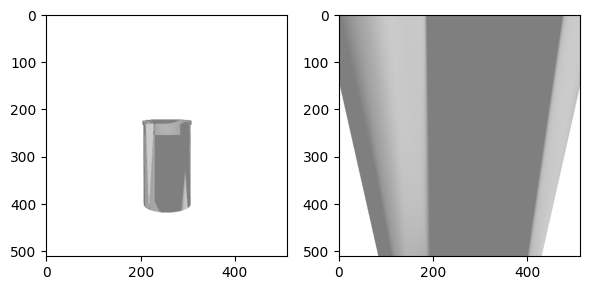

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(6, 4))
ax[0].imshow(guidances_2d[0][0, ..., :3].detach().cpu().numpy())
ax[1].imshow(rendered_mesh[0, ..., :3].detach().cpu().numpy())

plt.tight_layout()
plt.show()

In [ ]:
import pickle as pkl

torch.save(model.state_dict(), "/content/nsf")
pkl.dump(model, open("nsf.pkl", 'wb'))
pkl.dump(losses, open("losses.pkl", 'wb'))

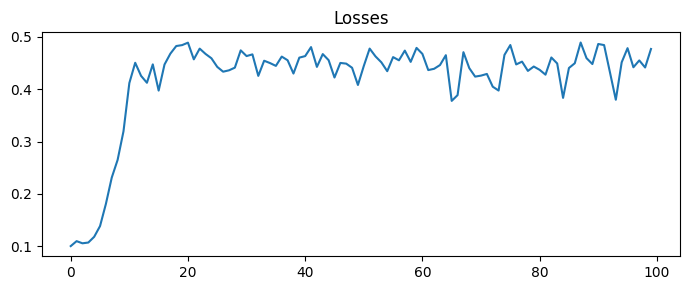

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,3))

ax.plot(losses)
ax.set_title("Losses")

plt.tight_layout()
plt.show()

In [ ]:
out_fig = plot_scene({
    "Out mesh": {
        "mesh": sampled_mesh
    }
})
out_fig.show()

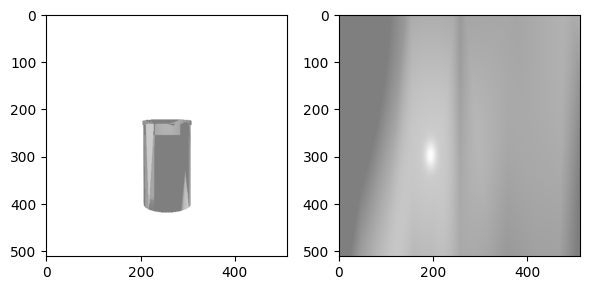

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(6, 4))
ax[0].imshow(guidances_2d[0][0, ..., :3].detach().cpu().numpy())
ax[1].imshow(rendered_mesh[0, ..., :3].detach().cpu().numpy())

plt.tight_layout()
plt.show()

# 3D guidance deformation

In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 20000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

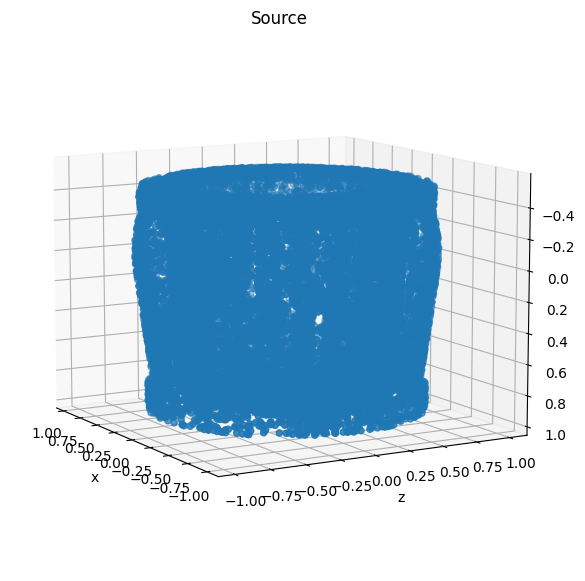

In [ ]:
######## Source mesh: to be deformed following the 2D guidance ########
# Load 3D model
src_verts, src_faces, _ = load_obj(meshes_paths[6])
src_faces_idx = src_faces.verts_idx.to(device)
src_verts = src_verts.to(device)

# Normalize 3D model (so it is centered in a sphere of radius 1 at (0,0,0)
center = src_verts.mean(0)
src_verts = src_verts - center
scale = max(src_verts.abs().max(0)[0])
src_verts = src_verts / scale

# Build mesh
src_mesh = Meshes(verts=[src_verts], faces=[src_faces_idx])

# Visualize mesh
# src_mesh = ico_sphere(4, device)
plot_pointcloud(mesh=src_mesh,title="Source")

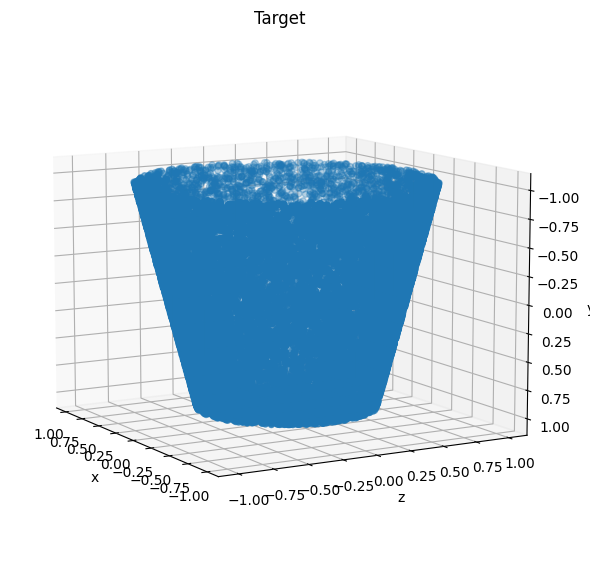

In [ ]:
######## Target mesh: from which the 2D guidance comes from ########
# Load 3D model
trg_verts, trg_faces, _ = load_obj(meshes_paths[9])
trg_faces_idx = trg_faces.verts_idx.to(device)
trg_verts = trg_verts.to(device)

# Normalize 3D model (so it is centered in a sphere of radius 1 at (0,0,0)
center = trg_verts.mean(0)
trg_verts = trg_verts - center
scale = max(trg_verts.abs().max(0)[0])
trg_verts = trg_verts / scale

# Build mesh
trg_mesh = Meshes(verts=[trg_verts], faces=[trg_faces_idx])

# Visualize mesh
plot_pointcloud(mesh=trg_mesh,title="Target")

In [ ]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [ ]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

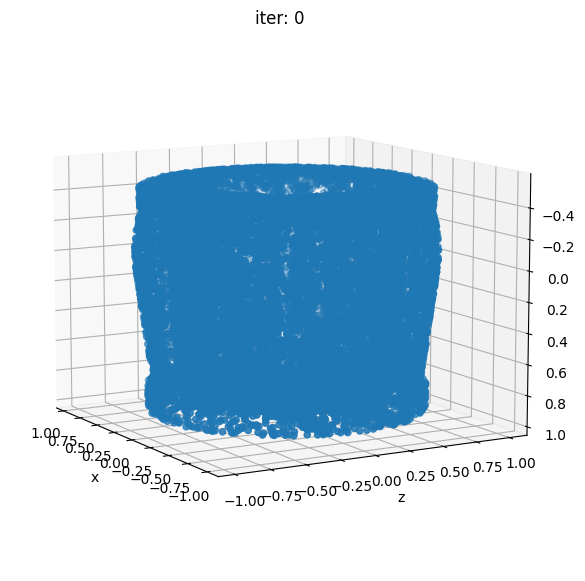

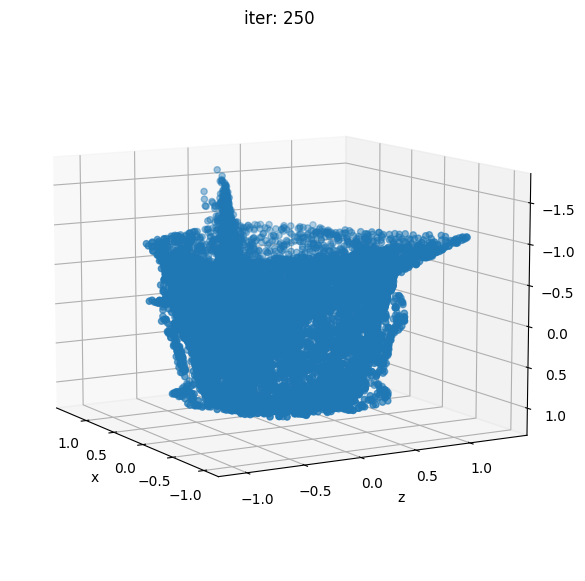

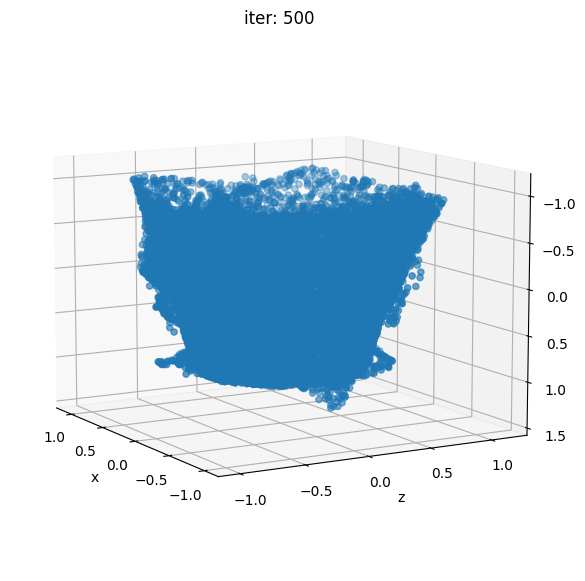

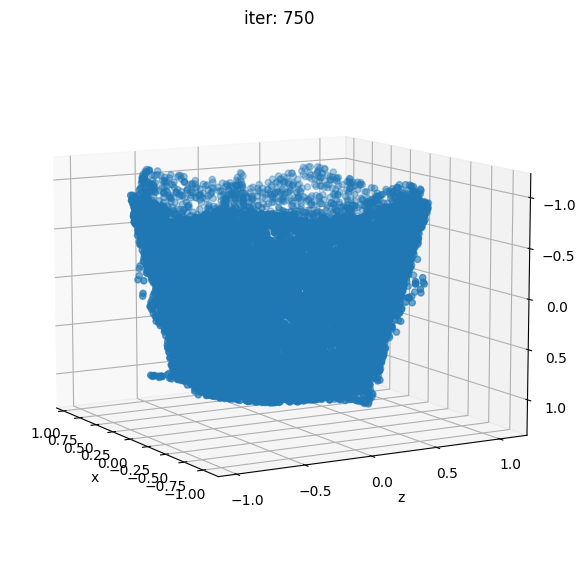

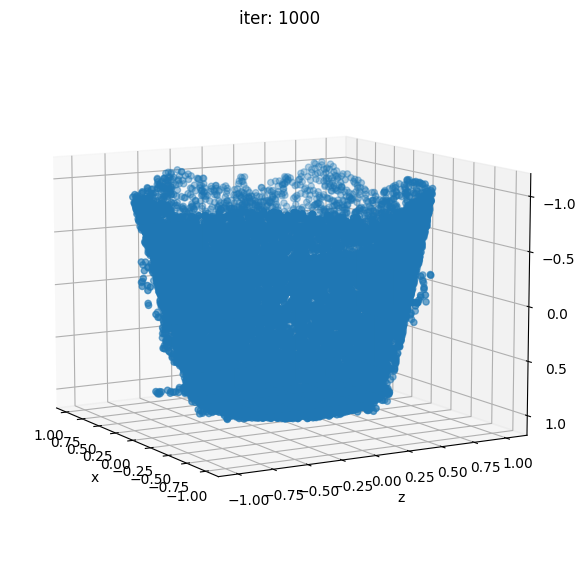

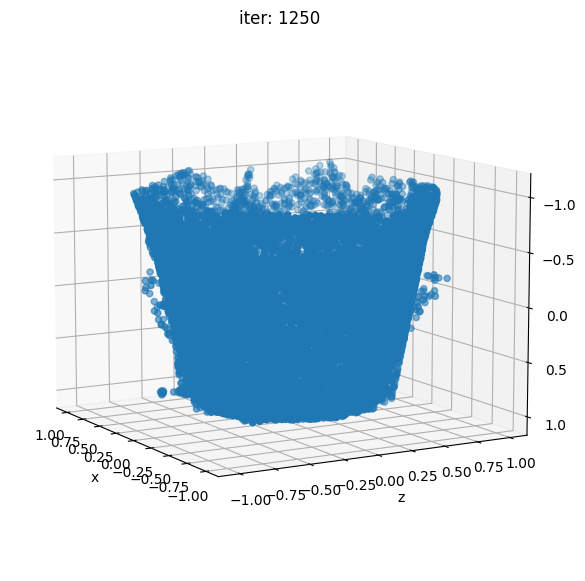

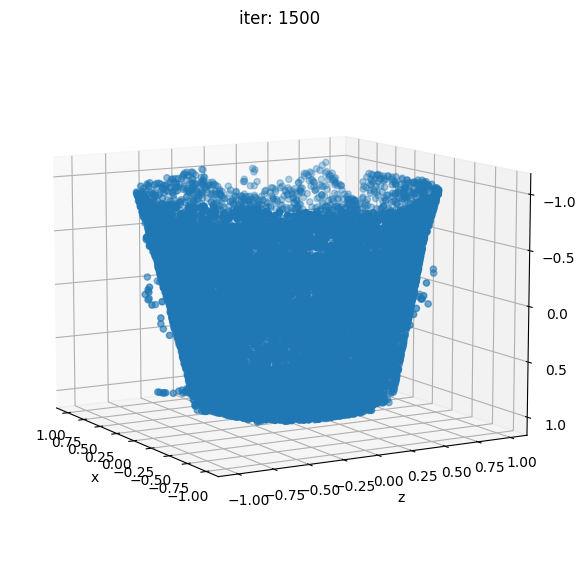

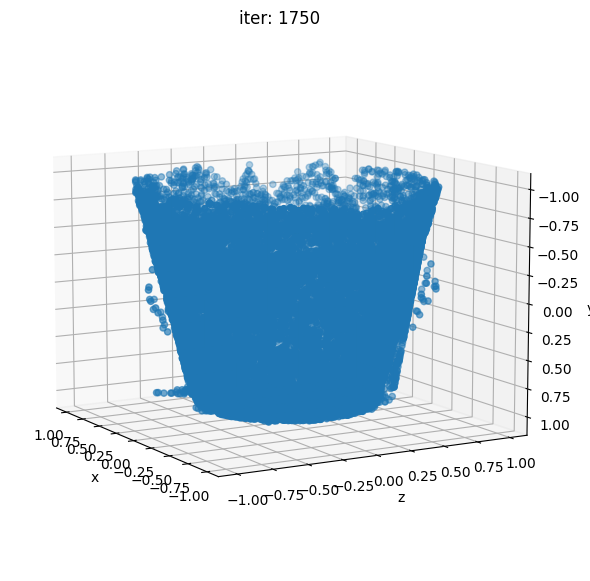

In [ ]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))

    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()

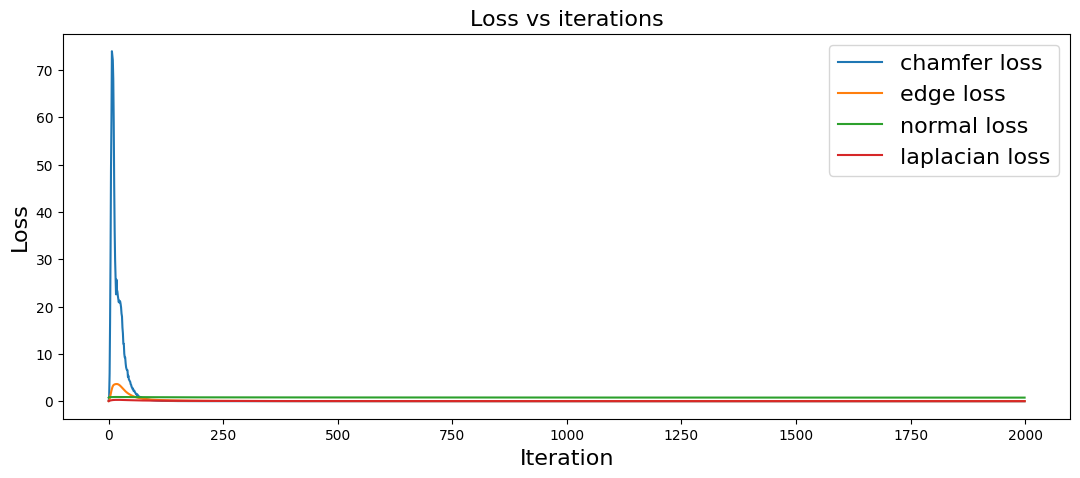

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

# Fitting mesh with rendered mesh

In [26]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/drive/folders/1SRWjFd98IfoWbOm20_RnB90DKem6RYaY?usp=sharing",

    # Networks
    'hidden_dim' : 256,
    'print_debug' : True,
    'verts_dim' : 3,
    'emb_net_depth' : 4,
    'disp_dim' : 1,
    'disp_net_depth' : 2,
    'norm_ratio' : 0.1,

    # Rendering
    'rendered_items' : 4,
    'net_rendered_items' : 16
}

In [1]:
!pip install open3d gdown --quiet

In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import open3d as o3d
import gdown
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid
from google.colab import output
output.enable_custom_widget_manager()

--2024-01-05 16:03:58--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.5’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-01-05 16:03:58 (20.5 MB/s) - ‘plot_image_grid.py.5’ saved [1608/1608]



In [27]:
if not os.path.exists(global_var['mesh_data_path']):
    print("[LOG] Starting dataset download...")
    gdown.download_folder(url = global_var['mesh_data_url'],
        output = global_var['mesh_data_path'],
        quiet=True)
    print("[LOG] Dataset download ended!")

else:
    print("[LOG] Mesh dataset already downloaded!")

[LOG] Starting dataset download...
[LOG] Dataset download ended!


In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2024-01-05 16:03:58--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj.3’

cow.obj.3           100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2024-01-05 16:03:58 (12.4 MB/s) - ‘data/cow_mesh/cow.obj.3’ saved [330659/330659]

--2024-01-05 16:03:58--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl.3’

cow.mtl.3           100%[=

In [28]:
def get_dataset_meshes(dataset_path):
    meshes_paths = []
    meshes = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)

    meshes_paths.sort()

    for m in meshes_paths:
        meshes.append(load_objs_as_meshes([m],device=device))

    return meshes_paths, meshes

def get_mesh(obj_path):
    verts, faces_idxs, _ = load_obj(obj_path)
    faces = faces_idxs.verts_idx

    # Initialize each vertex to be white in color since this feature isn't required in our project
    verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    mesh = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
    )

    return mesh

meshes_paths, meshes = get_dataset_meshes(global_var['mesh_data_path'])

In [47]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
# mesh = load_objs_as_meshes([obj_filename], device=device)  # OLD -------------------------------
mesh = load_objs_as_meshes([meshes_paths[9]], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

In [48]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles.
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different
# viewing angles. All the cameras helper methods support mixed type inputs and
# broadcasting. So we can view the camera from the a distance of dist=2.7, and
# then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])

# Define the settings for rasterization and shading. Here we set the output
# image to be of size 128X128. As we are rendering images for visualization
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
# rasterize_meshes.py for explanations of these parameters.  We also leave
# bin_size and max_faces_per_bin to their default values of None, which sets
# their values using heuristics and ensures that the faster coarse-to-fine
# rasterization method is used.  Refer to docs/notes/renderer.md for an
# explanation of the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured
# Phong shader will interpolate the texture uv coordinates for each vertex,
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...],
                                           T=T[None, i, ...]) for i in range(num_views)]

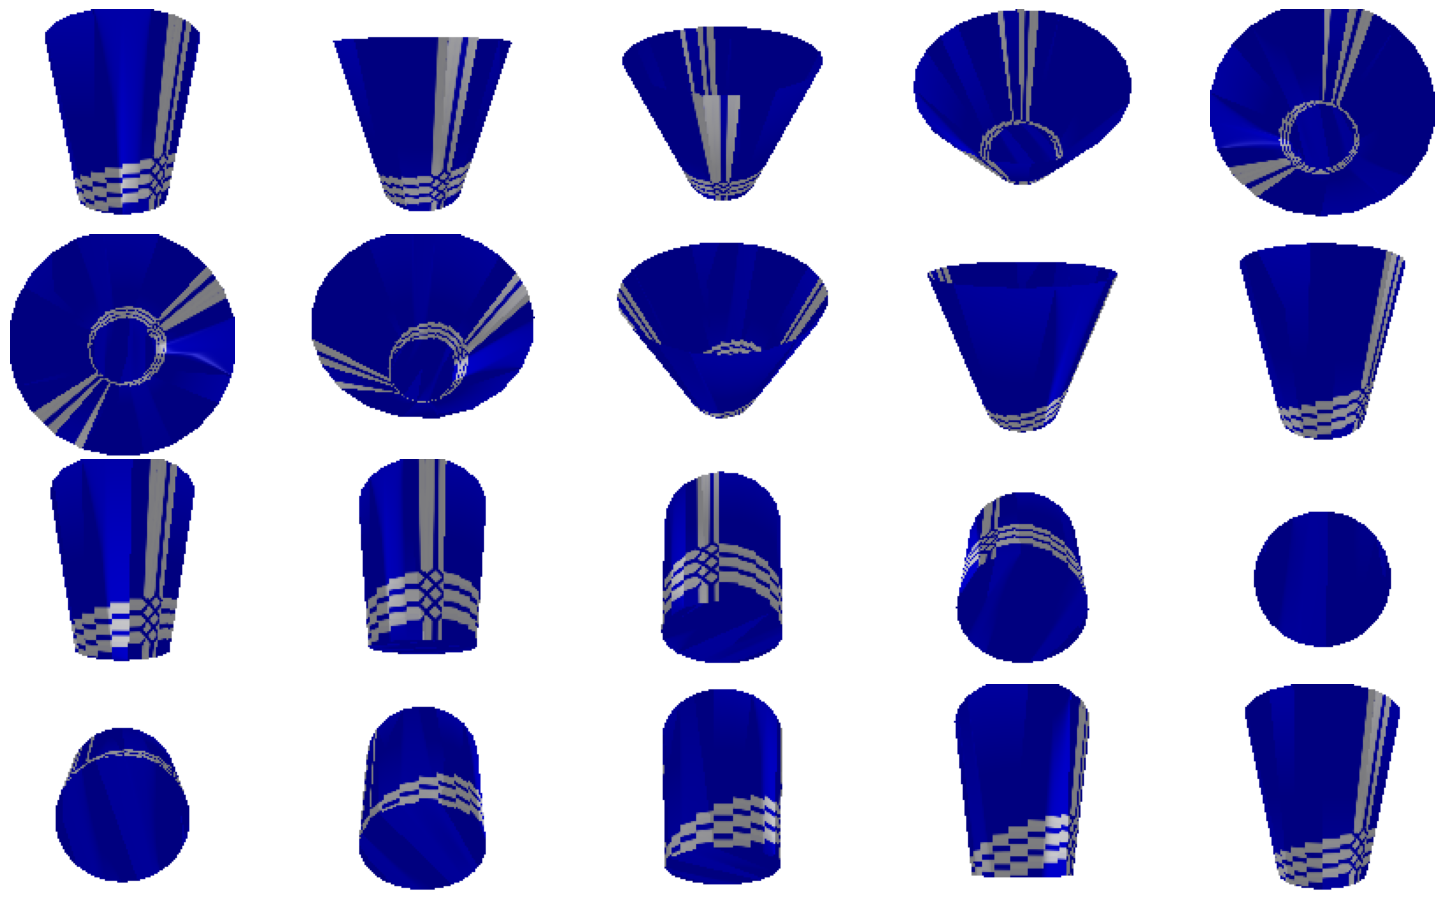

In [49]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

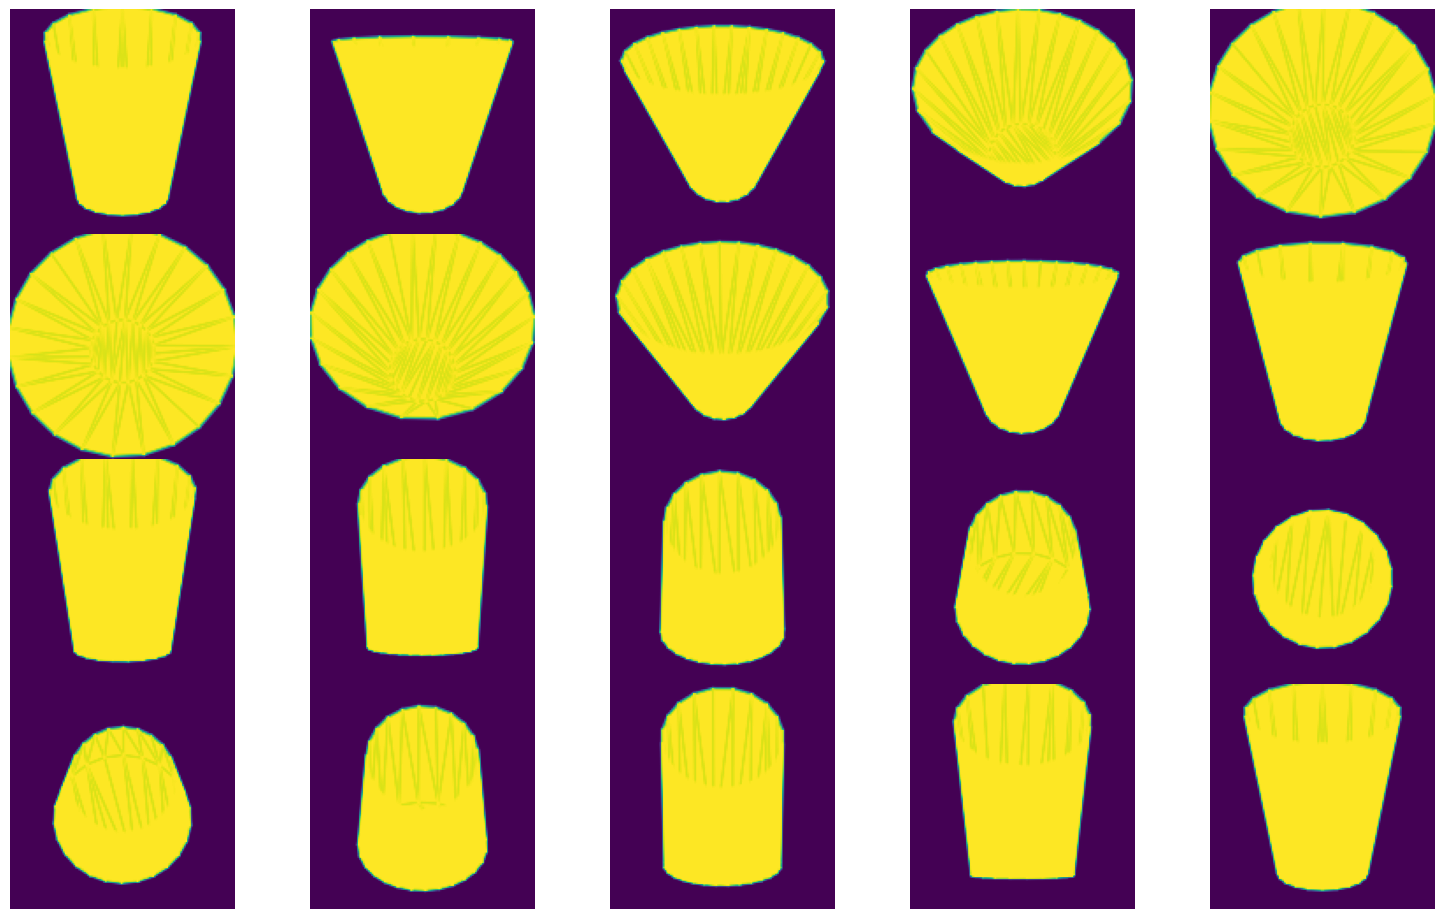

In [50]:
# Rasterization settings for silhouette rendering
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [51]:
# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_rgb[1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [87]:
# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device) # OLD ----------------

# # Load obj file
# src_mesh = load_objs_as_meshes([meshes_paths[3]], device=device)

# # We scale normalize and center the target mesh to fit in a sphere of radius 1
# # centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# # to its original center and scale.  Note that normalizing the target mesh,
# # speeds up the optimization but is not necessary!
# src_verts = src_mesh.verts_packed()
# src_N = src_verts.shape[0]
# src_center = src_verts.mean(0)
# src_scale = max((src_verts - src_center).abs().max(0)[0])
# src_mesh.offset_verts_(-src_center)
# src_mesh.scale_verts_((1.0 / float(src_scale)));

In [88]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

In [99]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True) # Questo corrisponde all'offset da dare ai vertici
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

torch.Size([2562, 3])


  0%|          | 0/2000 [00:00<?, ?it/s]

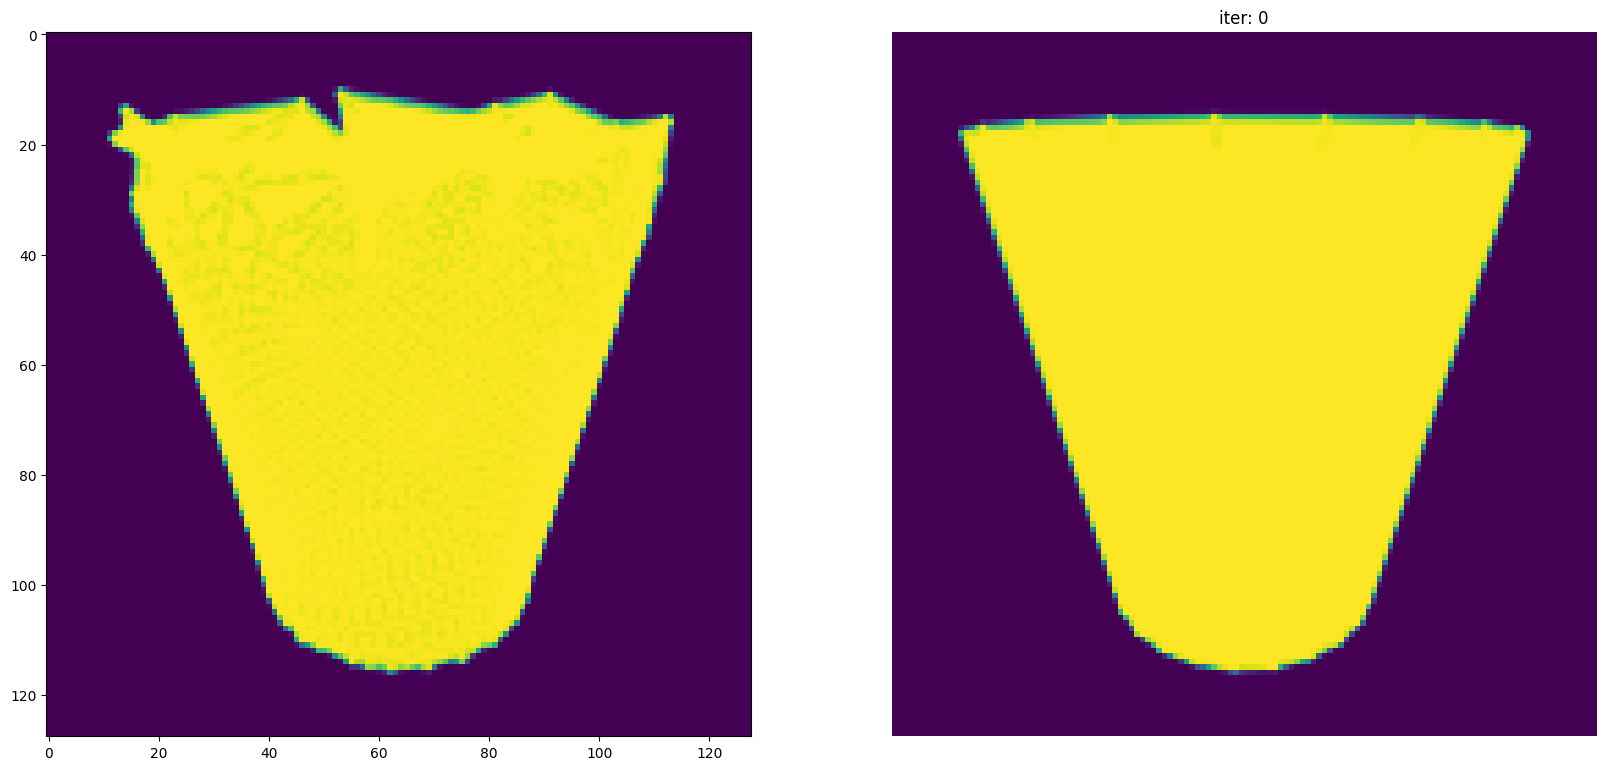

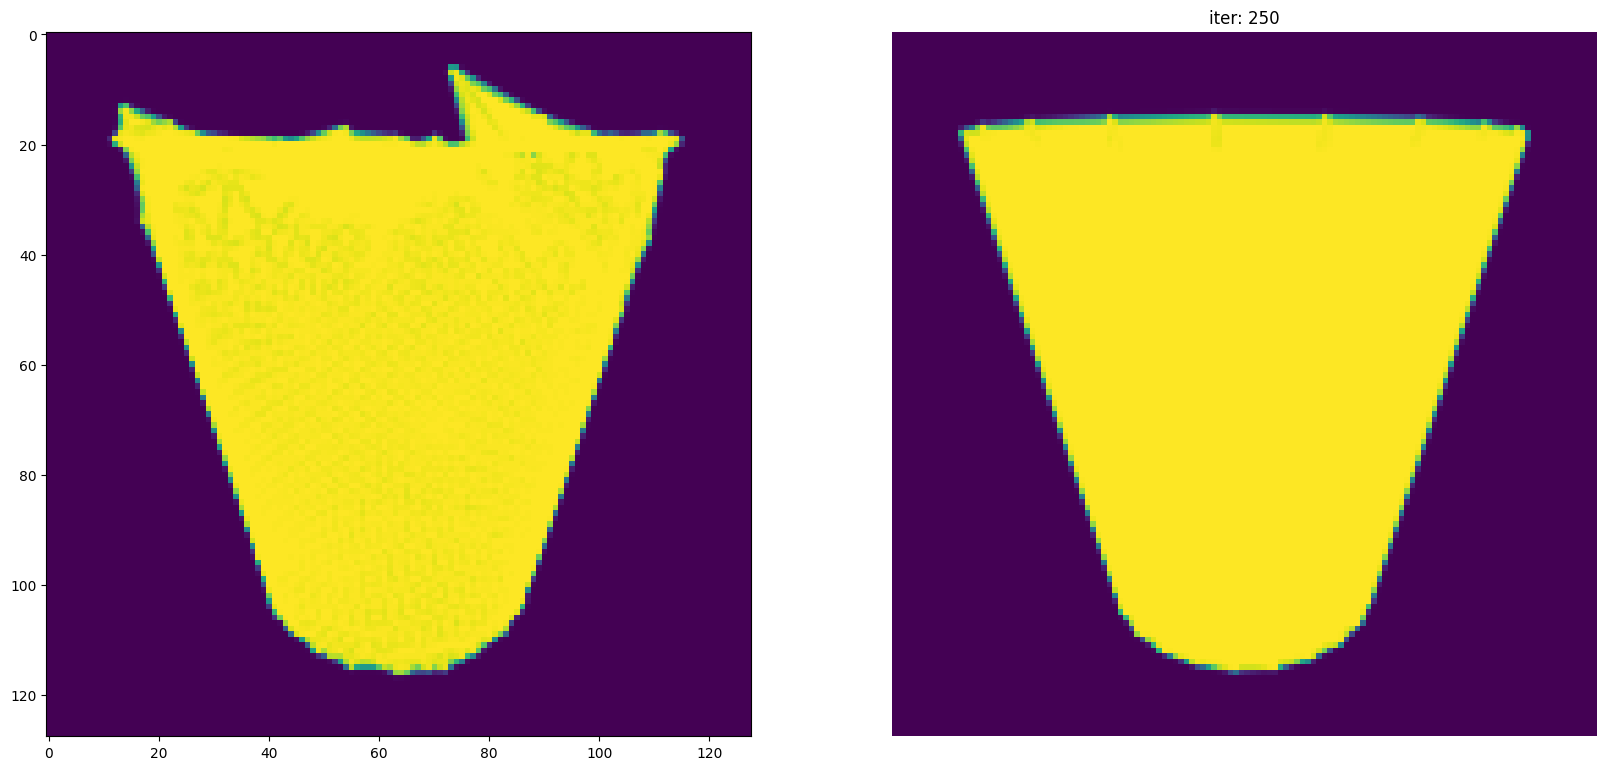

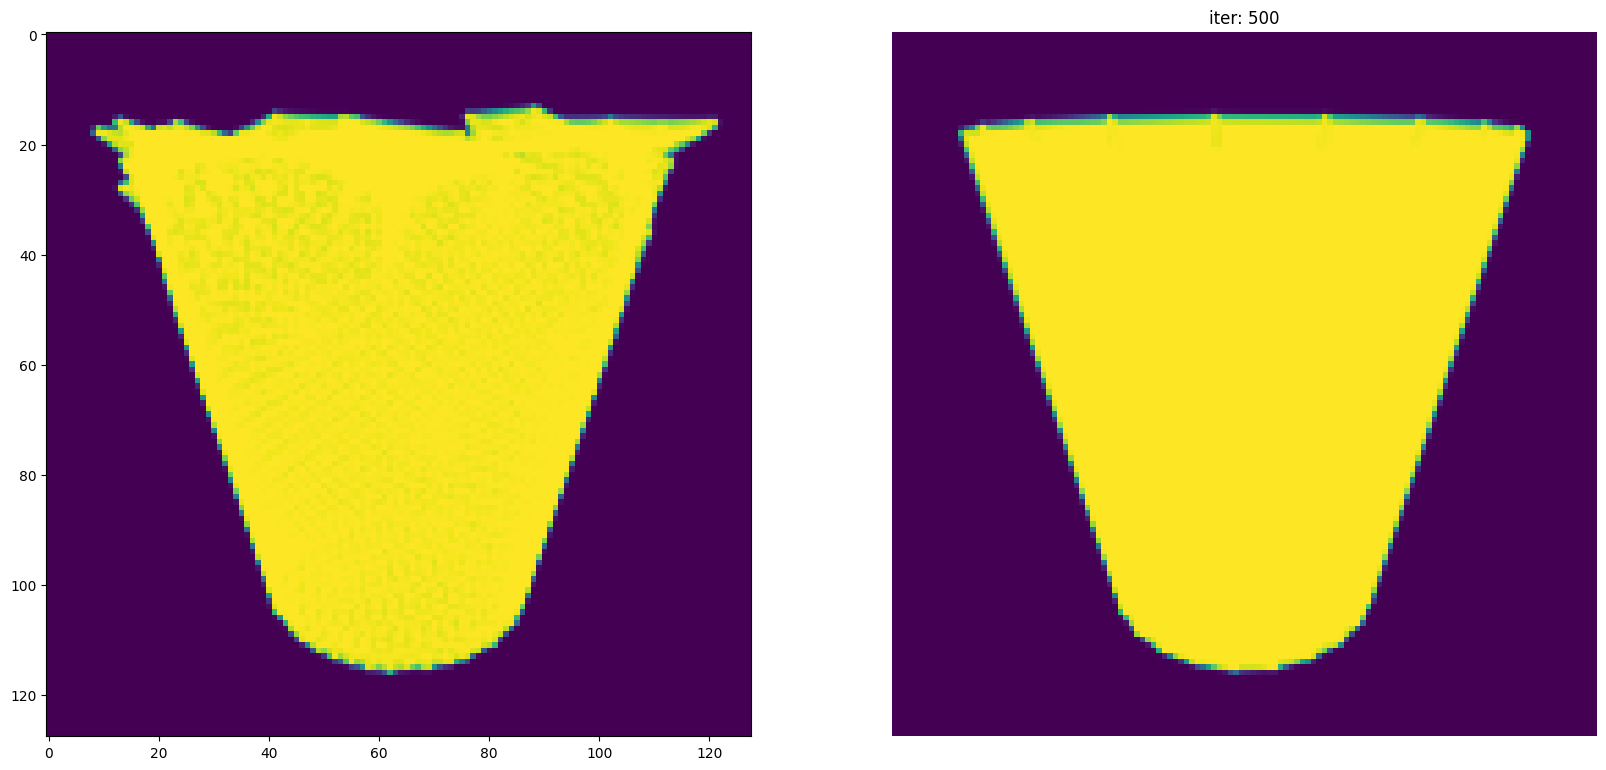

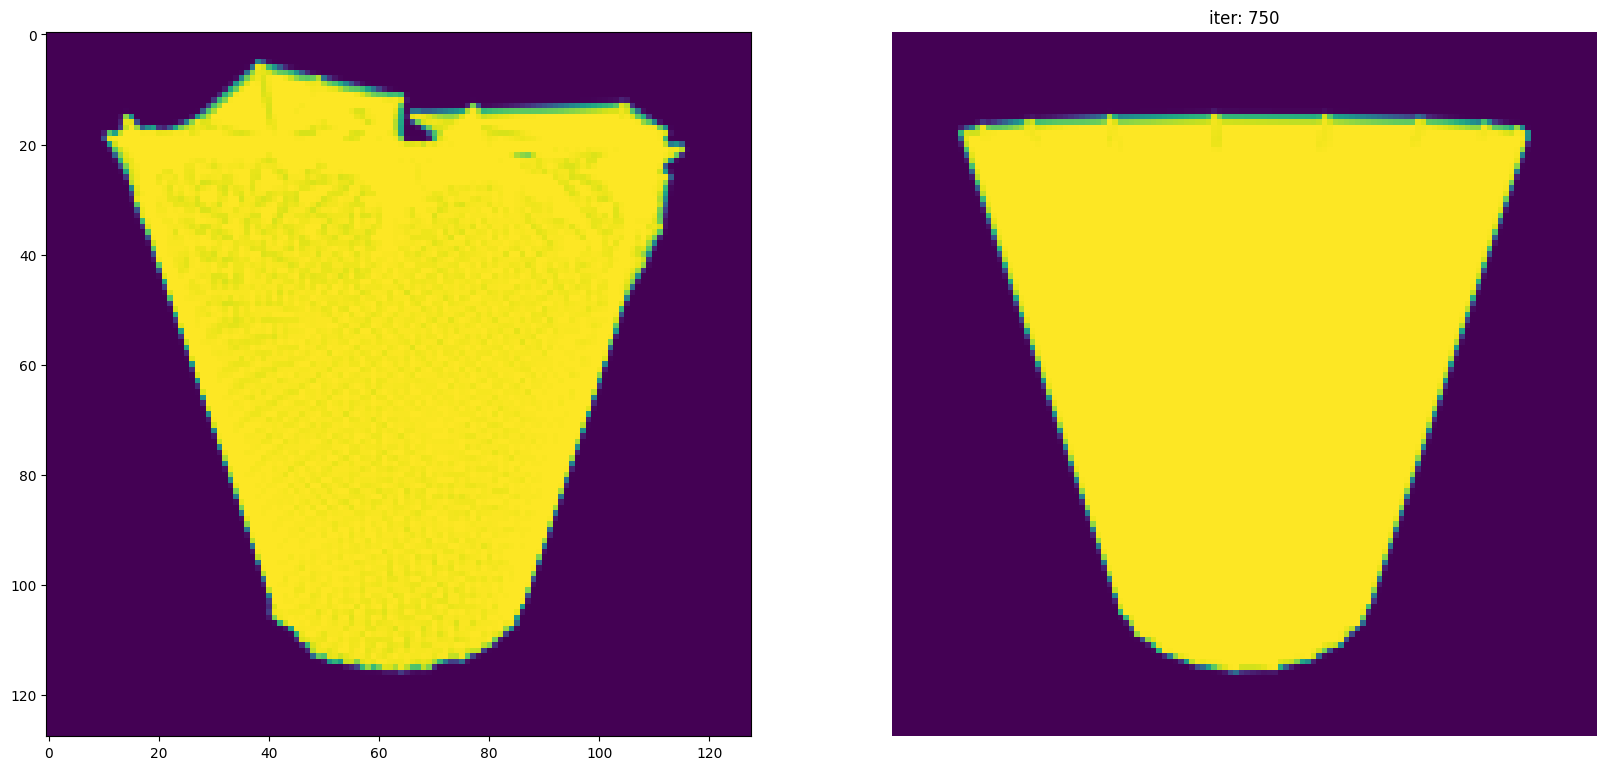

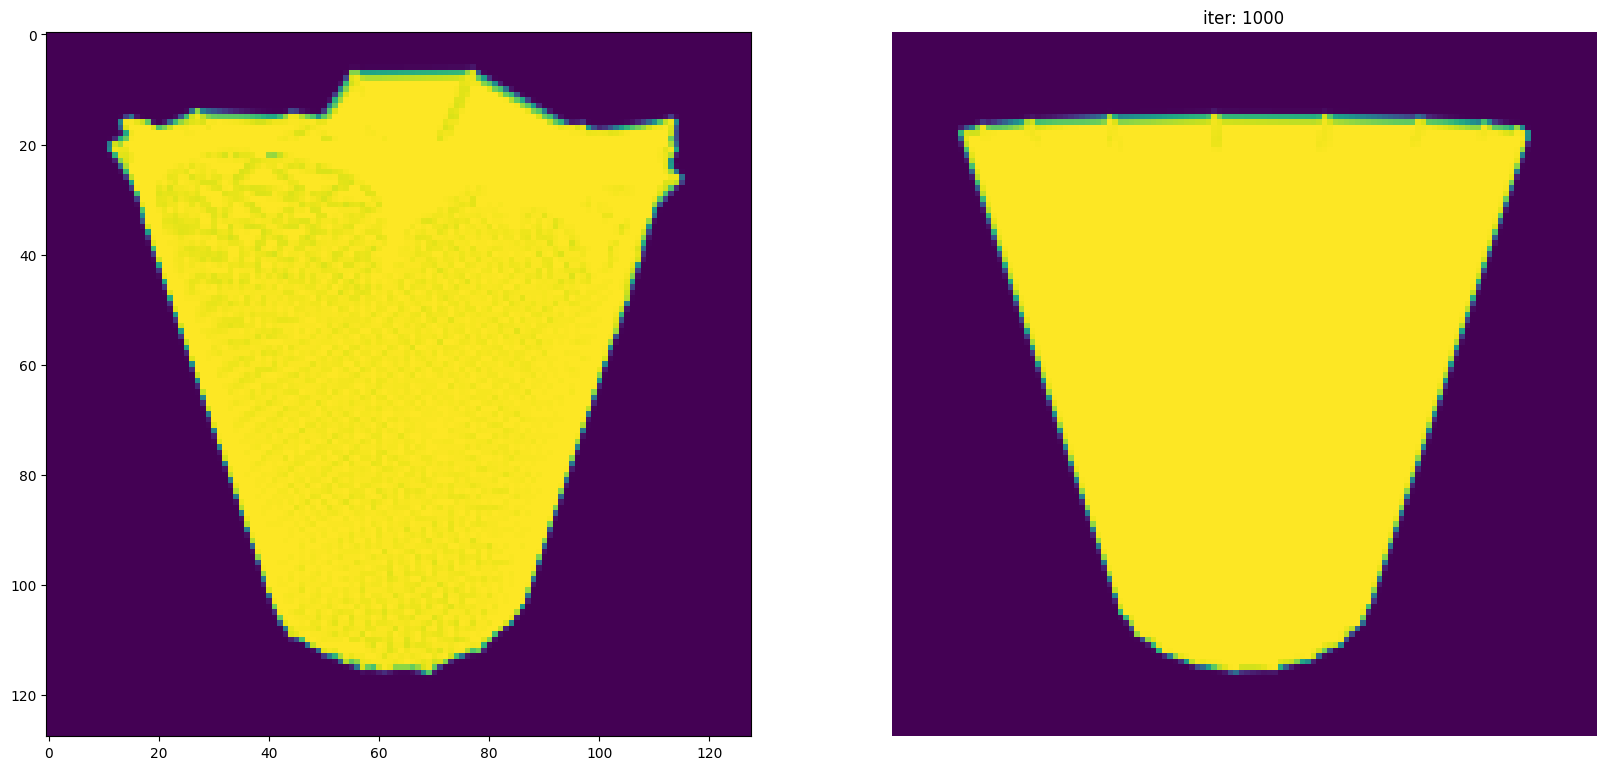

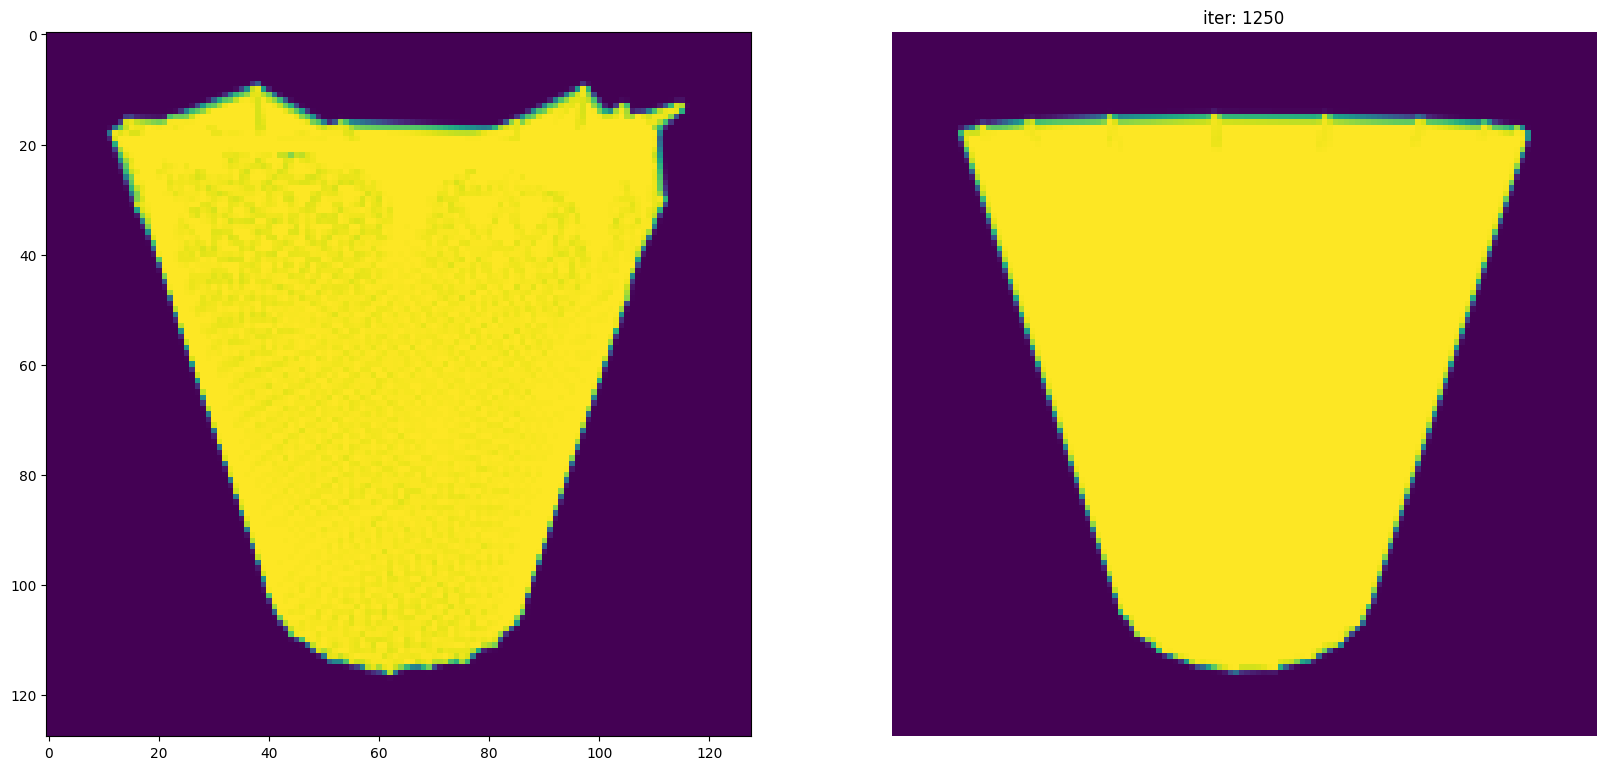

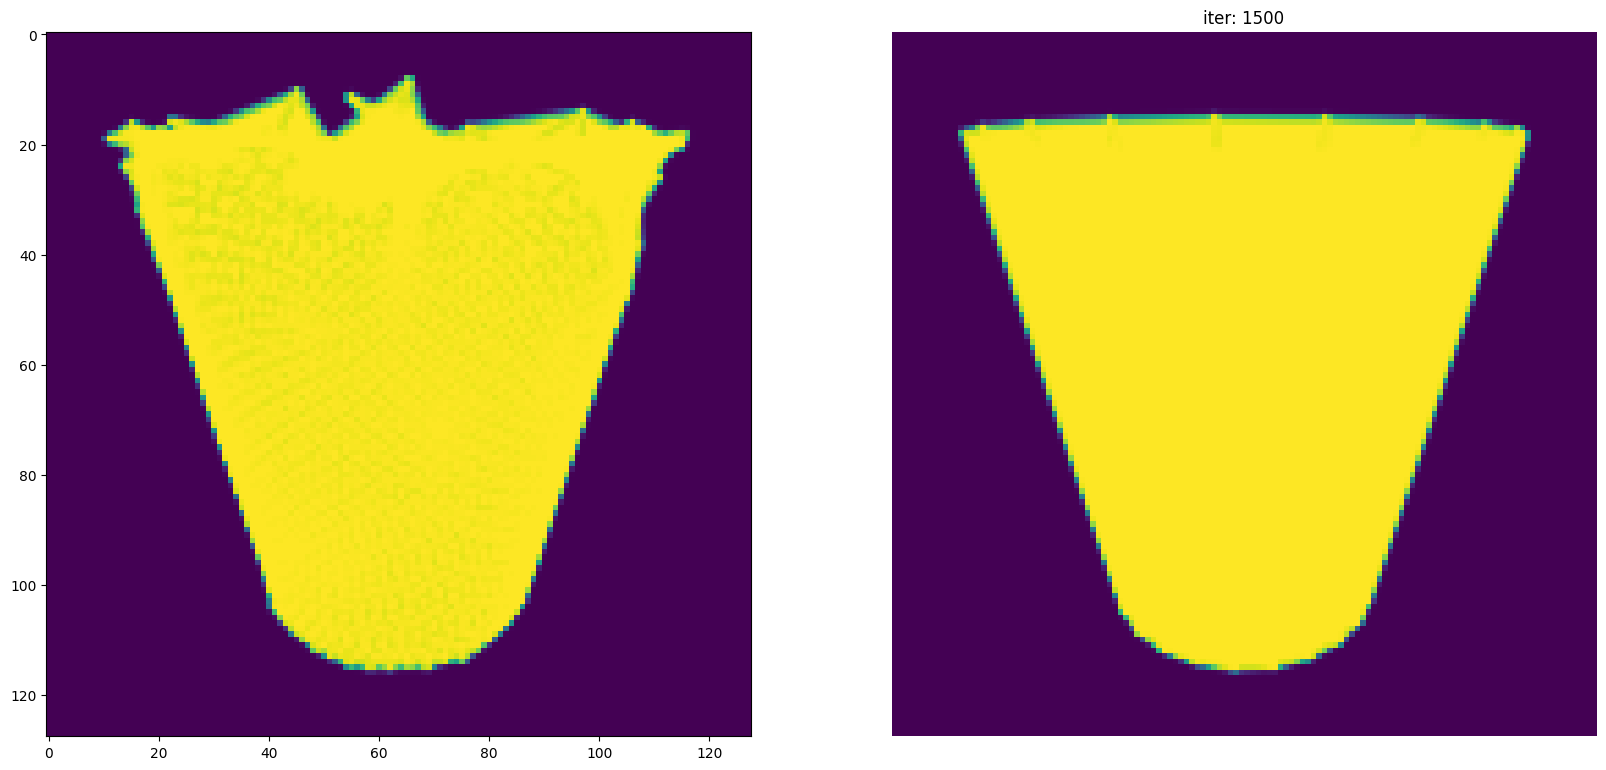

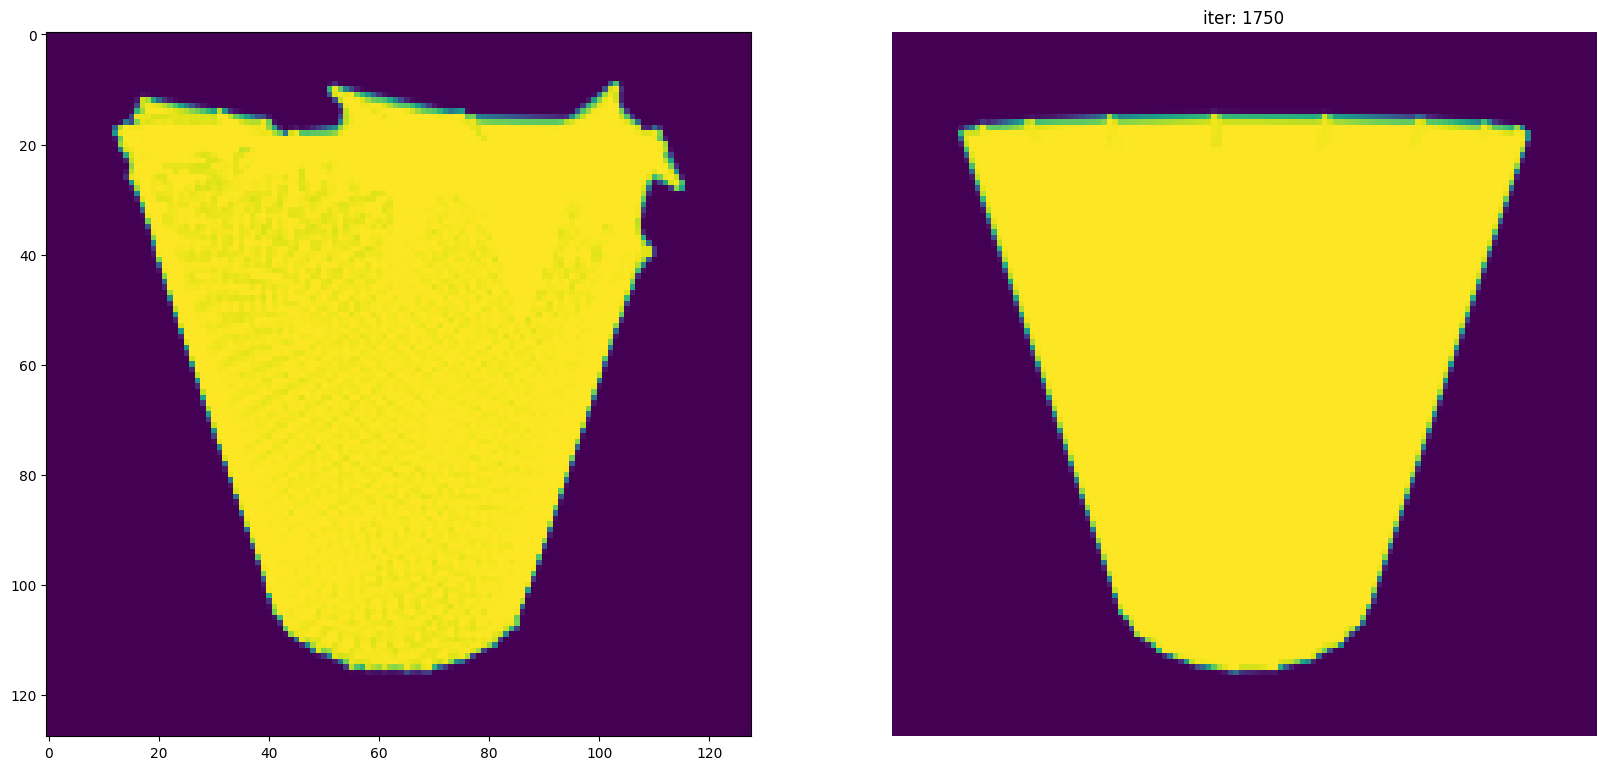

In [97]:
with tqdm(range(Niter),leave=True):
  for i in loop:
      # Initialize optimizer
      optimizer.zero_grad()

      # Deform the mesh
      new_src_mesh = src_mesh.offset_verts(deform_verts)

      # Losses to smooth /regularize the mesh shape
      loss = {k: torch.tensor(0.0, device=device) for k in losses}
      update_mesh_shape_prior_losses(new_src_mesh, loss)

      # Compute the average silhouette loss over two random views, as the average
      # squared L2 distance between the predicted silhouette and the target
      # silhouette from our dataset
      for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
          images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
          predicted_silhouette = images_predicted[..., 3]
          loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
          loss["silhouette"] += loss_silhouette / num_views_per_iteration

      # Weighted sum of the losses
      sum_loss = torch.tensor(0.0, device=device)
      for k, l in loss.items():
          sum_loss += l * losses[k]["weight"]
          losses[k]["values"].append(float(l.detach().cpu()))


      # Print the losses
      loop.set_description("total_loss = %.6f" % sum_loss)

      # Plot mesh
      if i % plot_period == 0:
          visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                              target_image=target_silhouette[1])

      # Optimization step
      sum_loss.backward()
      optimizer.step()

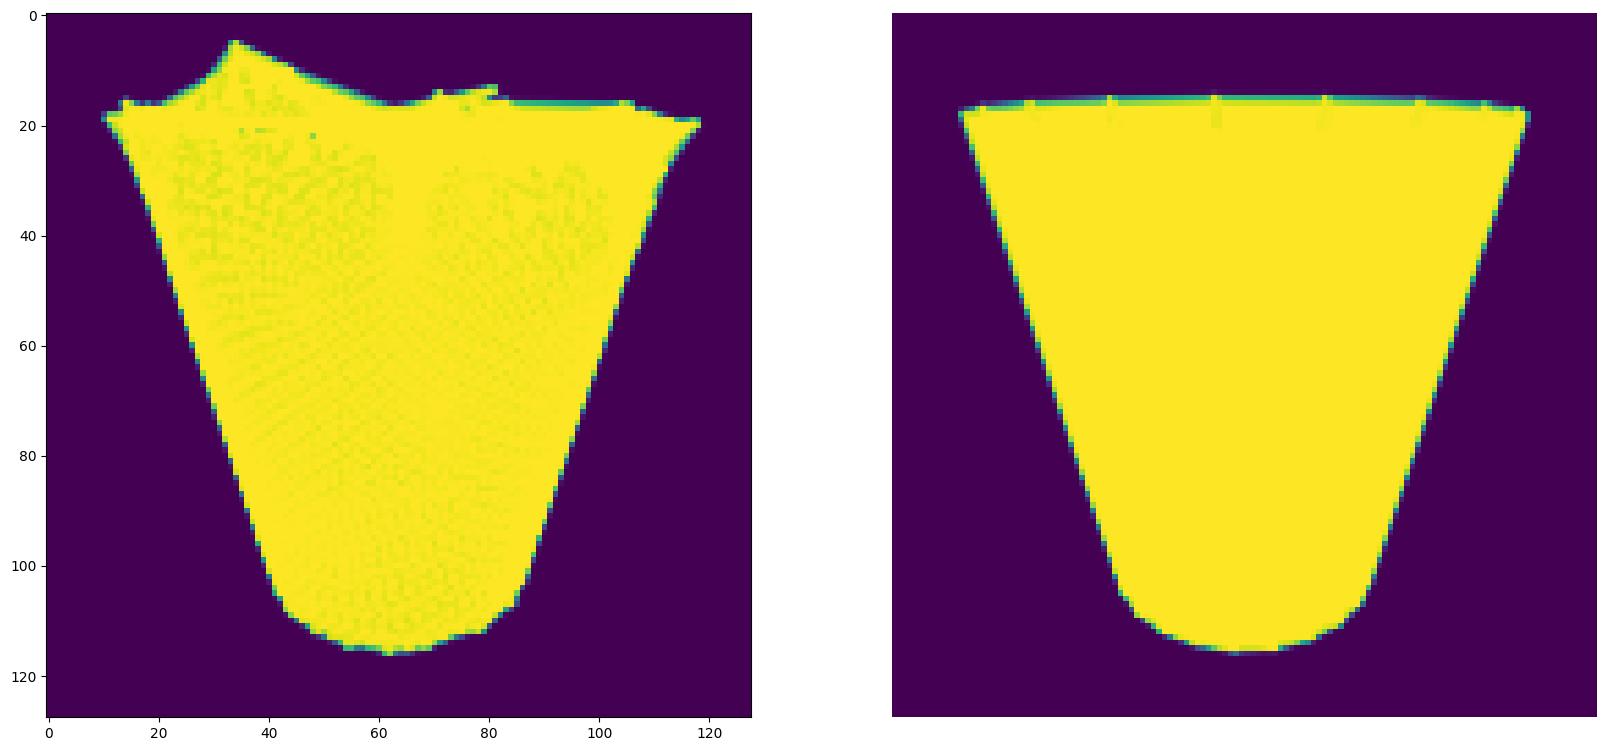

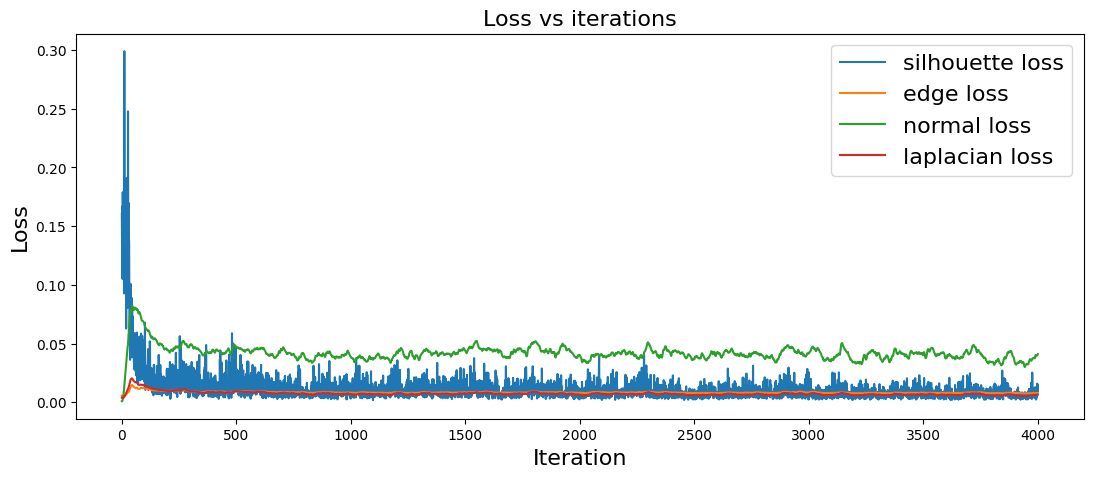

In [98]:
visualize_prediction(new_src_mesh, silhouette=True,
                     target_image=target_silhouette[1])
plot_losses(losses)

In [92]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

In [93]:
def final_pointcloud(src_mesh,final_mesh):
    # Sample points uniformly from the surface of the mesh.
    src_points = sample_points_from_meshes(src_mesh, 20000)
    src_x, src_y, src_z = src_points.clone().detach().cpu().squeeze().unbind(1)

    final_points = sample_points_from_meshes(final_mesh, 20000)
    final_x, final_y, final_z = final_points.clone().detach().cpu().squeeze().unbind(1)

    fig = plt.figure(figsize=(16, 16))

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter3D(src_x, src_z, -src_y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title("Target mesh")
    ax.view_init(190, 30)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter3D(final_x, final_z, -final_y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title("Deformed source")
    ax.view_init(190, 30)

    plt.show()

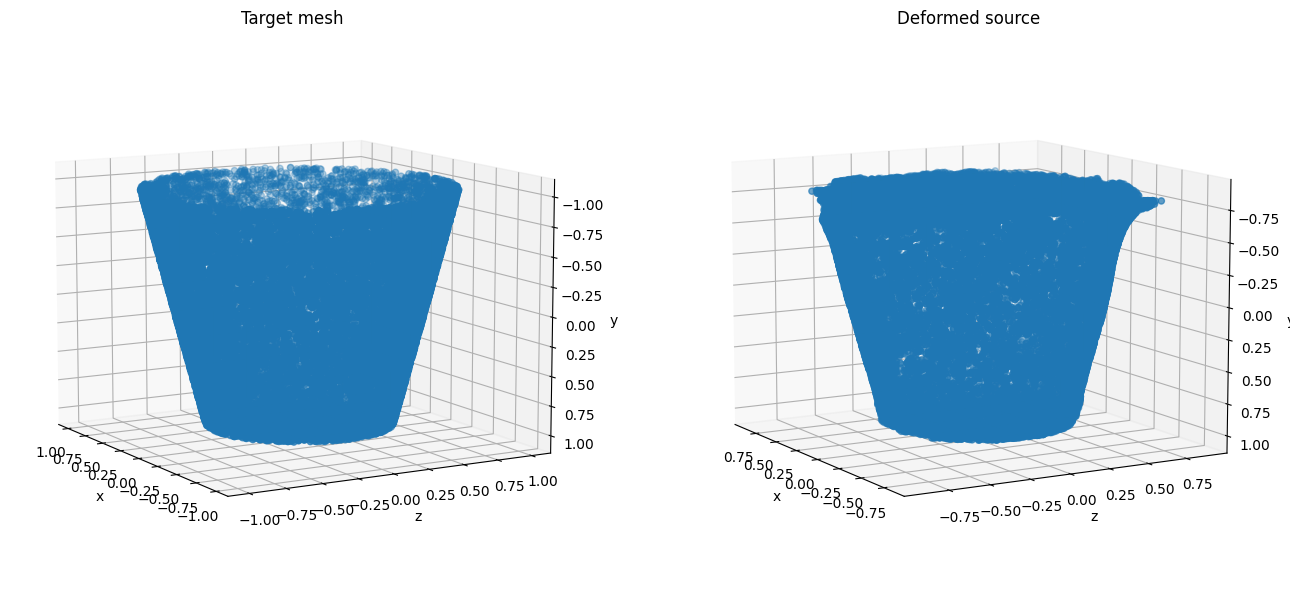

In [94]:
final_filename = "final_model.obj"
final_mesh = load_objs_as_meshes([final_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
verts = final_mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
final_mesh.offset_verts_(-center)
final_mesh.scale_verts_((1.0 / float(scale)));

# Visualize mesh
final_pointcloud(src_mesh=mesh,final_mesh=final_mesh)

In [95]:
def mesh_visualization(obj_file_path):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    fig = go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50
          )

    return fig

In [96]:
src_fig = mesh_visualization(meshes_paths[9])
final_fig = mesh_visualization("final_model.obj")

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    print_grid=False)

fig.append_trace(src_fig,row=1,col=1)
fig.append_trace(final_fig,row=1,col=2)
fig.update_layout(width=1000, margin=dict(r=10, l=10, b=10, t=10))
# fix the ratio in the top left subplot to be a cube
fig.update_layout(scene_aspectmode='cube')
# manually force the z-axis to appear twice as big as the other two
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=2))
# draw axes in proportion to the proportion of their ranges
fig.update_layout(scene_aspectmode='data')
# automatically produce something that is well proportioned using 'data' as the default
fig.update_layout(scene_aspectmode='auto')
fig.show()